# 直接使用预训练模型

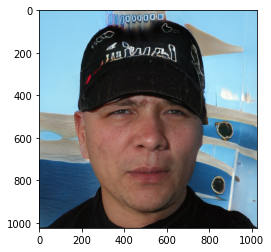

In [349]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToPILImage
with open('./pretrained_model/ffhq.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()  # torch.nn.Module
z = torch.randn([1, G.z_dim]).cuda()    # latent codes
c = None                                # class labels (not used in this example)
img = G(z, c)
img  = ((img.detach().cpu().squeeze() + 1)/2 * 255).clip(0, 255).int().permute(1,2,0)
plt.imshow(img)

# Genrate Demo

In [350]:
import legacy
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

In [351]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [352]:
# 兼容 tf 模型导出的权重文件（实际上该模已经是 Pytorch 版本的了，可以直接 pickle.load()）
models = legacy.load_network_pkl(open('./pretrained_model/ffhq.pkl', 'rb'))
models.keys()

dict_keys(['G', 'D', 'G_ema', 'training_set_kwargs', 'augment_pipe'])

In [353]:
G = models['G_ema'].to(device)
count = 0
for p in G.parameters():
    count += p.numel()
print(f"G has {count} params")

G has 30370060 params


In [354]:
label = torch.zeros([1, G.c_dim], device=device)
label

tensor([], device='cuda:0', size=(1, 0))

latent code: torch.Size([1, 512]) torch.float64


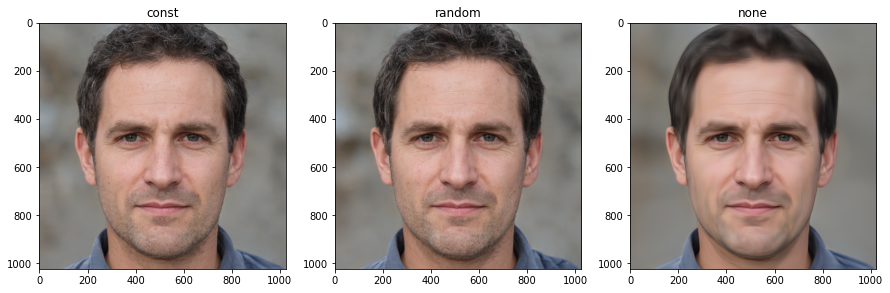

In [355]:
noise_modes = ['const', 'random', 'none']
seed = 1
truncation_psi = 0.4
z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
print("latent code:", z.shape, z.dtype)

fig = plt.figure(figsize=(15,15))
for i, noise_mode in enumerate(noise_modes):
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clip(0, 255).to(torch.uint8)
    img = Image.fromarray(img[0].cpu().numpy(), 'RGB')
    plt.subplot(1, len(noise_modes), i+1)
    plt.imshow(img)
    plt.title(noise_mode)

# Project Latent code

In [356]:
import legacy
import dnnlib
import pickle
import torch
import PIL
import matplotlib.pyplot as plt

seed = 303
np.random.seed(seed)
torch.manual_seed(seed)
device = torch.device('cuda')

In [357]:
network_pkl='./pretrained_model/ffhq.pkl'
with dnnlib.util.open_url(network_pkl) as fp:
    data = legacy._LegacyUnpickler(fp).load()

In [358]:
with dnnlib.util.open_url(network_pkl) as fp:
    data = pickle.load(fp)

In [359]:
G = data['G_ema'].requires_grad_(False).to(device)

Text(0.5, 1.0, 'raw target img')

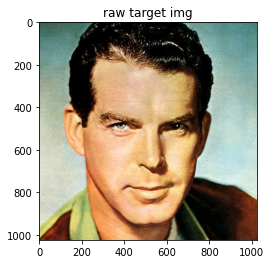

In [360]:
target_fname = './000080.jpg'
target_pil = PIL.Image.open(target_fname).convert('RGB')
plt.imshow(target_pil)
plt.title("raw target img")

w: 1024, h: 1024


Text(0.5, 1.0, '[Croped+Resized] target img')

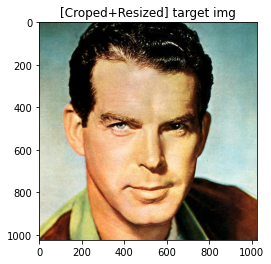

In [361]:
w, h = target_pil.size
s = min(w, h)
print(f"w: {w}, h: {h}")

# crop
target_pil = target_pil.crop(((w-s)//2, (h-s)//2, (w+s)//2, (h+s)//2))
# resize
target_pil = target_pil.resize((G.img_resolution, G.img_resolution), PIL.Image.Resampling.LANCZOS)

plt.imshow(target_pil)
plt.title("[Croped+Resized] target img")

In [362]:
target_uint8 = np.asarray(target_pil, dtype=np.uint8)
target_uint8.shape

(1024, 1024, 3)

In [363]:
import copy
import torch.nn.functional as F
def project(
    G,
    target: torch.Tensor, # [C,H,W] and dynamic range [0,255], W & H must match G output resolution
    *,
    num_steps                  = 1000,
    w_avg_samples              = 10000,
    initial_learning_rate      = 0.1,
    initial_noise_factor       = 0.05,
    lr_rampdown_length         = 0.25,
    lr_rampup_length           = 0.05,
    noise_ramp_length          = 0.75,
    regularize_noise_weight    = 1e5,
    verbose                    = False,
    device: torch.device
):
    assert target.shape == (G.img_channels, G.img_resolution, G.img_resolution)

    def logprint(*args):
        if verbose:
            print(*args)

    G = copy.deepcopy(G).eval().requires_grad_(False).to(device) # type: ignore

    # Compute w stats.
    logprint(f'Computing W midpoint and stddev using {w_avg_samples} samples...')
    z_samples = np.random.RandomState(123).randn(w_avg_samples, G.z_dim)  # [10000, 512]
    print("z_samples shape:", z_samples.shape)
    w_samples = G.mapping(torch.from_numpy(z_samples).to(device), None)  # [10000, 18, 512]
    print("w_samples shape:", w_samples.shape)
    w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)       # [10000, 1, 512]
    w_avg = np.mean(w_samples, axis=0, keepdims=True)      # [1, 1, 512]
    # [FOCUS] sum 没有指定 axis, 返回一个标量数值
    w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5
    print(f"w_avg shape: {w_avg.shape}, w_std shape: {w_std}")
    
    # Setup noise inputs.
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

    # Load VGG16 feature detector.
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)

    # Features for target image.
    target_images = target.unsqueeze(0).to(device).to(torch.float32) # [1, 3, 1024, 1024]
    if target_images.shape[2] > 256:
        target_images = F.interpolate(target_images, size=(256, 256), mode='area') # [1, 3, 256, 256]
    target_features = vgg16(target_images, resize_images=False, return_lpips=True) # [1, 7995392]
    print("target_features shape:", target_features.shape)

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # [1, 1, 512]
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device) # [B, 1, 512]
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)

    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True

    lr_list = []
    for step in range(num_steps):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        lr_list.append(lr)
        
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        # Synth images from opt_w.
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')

        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')

        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (target_features - synth_features).square().sum()

        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        logprint(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')

        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()
                
    # plot lr line
    fig, axes = plt.subplots(1,1, figsize=(15,5))
    axes.plot(lr_list, ls='-', marker=None)
    axes.set_xlabel("step", loc='right')
    axes.set_ylabel("lr", loc='top')
    axes.set_title("lr rate")
    axes.grid(which='both')
    axes.set_xlim(0)
    axes.set_ylim(0)
    axes.xaxis.set_minor_locator(plt.MultipleLocator(5))
    axes.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
    axes.legend(['lr'])
    return w_out.repeat([1, G.mapping.num_ws, 1])

Computing W midpoint and stddev using 10000 samples...
z_samples shape: (10000, 512)
w_samples shape: torch.Size([10000, 18, 512])
w_avg shape: (1, 1, 512), w_std shape: 10.005703685898359
target_features shape: torch.Size([1, 7995392])
step    1/200: dist 0.71 loss 24567.68
step    2/200: dist 0.66 loss 27640.99
step    3/200: dist 0.69 loss 25427.65
step    4/200: dist 0.61 loss 21591.20
step    5/200: dist 0.66 loss 16991.88
step    6/200: dist 0.60 loss 12125.00
step    7/200: dist 0.62 loss 7900.57
step    8/200: dist 0.61 loss 4633.88
step    9/200: dist 0.63 loss 3105.02
step   10/200: dist 0.61 loss 3334.43
step   11/200: dist 0.60 loss 4933.88
step   12/200: dist 0.53 loss 6615.50
step   13/200: dist 0.60 loss 7769.19
step   14/200: dist 0.56 loss 7763.62
step   15/200: dist 0.52 loss 7028.68
step   16/200: dist 0.53 loss 5718.35
step   17/200: dist 0.59 loss 4321.31
step   18/200: dist 0.53 loss 3163.20
step   19/200: dist 0.51 loss 2331.85
step   20/200: dist 0.50 loss 1753.

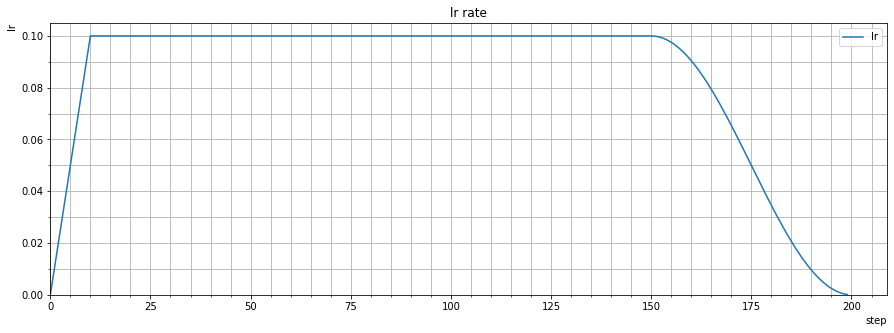

In [364]:
%%time
torch.backends.cudnn.benchmark = True
import time
start_time = time.perf_counter()

projected_w_steps = project(G, 
                            target=torch.tensor(target_uint8.transpose([2,0,1]), device=device),
                            num_steps=200,
                            w_avg_samples=10000,
                            device=device,
                            verbose=True
                           )
print (f'Elapsed: {(time.perf_counter()-start_time):.1f} s')

In [365]:
projected_w_steps.shape

torch.Size([200, 18, 512])

In [366]:
import os
# Render debug output: optional video and projected image and W vector.
outdir = './out/project/'
os.makedirs(outdir, exist_ok=True)

In [368]:
class MyCell(torch.nn.Module):
    def __init__(self):
        super(MyCell, self).__init__()
        self.linear = torch.nn.Linear(4, 4)

    def forward(self, x, h):
        new_h = torch.tanh(self.linear(x) + h)
        return new_h, new_h

my_cell = MyCell()
x, h = torch.rand(3, 4), torch.rand(3, 4)
traced_cell = torch.jit.trace(my_cell, (x, h))
print(traced_cell)

MyCell(
  original_name=MyCell
  (linear): Linear(original_name=Linear)
)


In [369]:
traced_cell(x, h)

(tensor([[0.8674, 0.8947, 0.7814, 0.4131],
         [0.4155, 0.8824, 0.7240, 0.9332],
         [0.7696, 0.9122, 0.8043, 0.6524]], grad_fn=<TanhBackward0>),
 tensor([[0.8674, 0.8947, 0.7814, 0.4131],
         [0.4155, 0.8824, 0.7240, 0.9332],
         [0.7696, 0.9122, 0.8043, 0.6524]], grad_fn=<TanhBackward0>))

In [374]:
traced_cell.graph

graph(%self.1 : __torch__.___torch_mangle_3.MyCell,
      %x : Float(3, 4, strides=[4, 1], requires_grad=0, device=cpu),
      %h : Float(3, 4, strides=[4, 1], requires_grad=0, device=cpu)):
  %linear : __torch__.torch.nn.modules.linear.___torch_mangle_2.Linear = prim::GetAttr[name="linear"](%self.1)
  %20 : Tensor = prim::CallMethod[name="forward"](%linear, %x)
  %11 : int = prim::Constant[value=1]() # /tmp/ipykernel_8723/1743065315.py:7:0
  %12 : Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu) = aten::add(%20, %h, %11) # /tmp/ipykernel_8723/1743065315.py:7:0
  %13 : Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu) = aten::tanh(%12) # /tmp/ipykernel_8723/1743065315.py:7:0
  %14 : (Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu), Float(3, 4, strides=[4, 1], requires_grad=1, device=cpu)) = prim::TupleConstruct(%13, %13)
  return (%14)

In [376]:
print(traced_cell.code)

def forward(self,
    x: Tensor,
    h: Tensor) -> Tuple[Tensor, Tensor]:
  linear = self.linear
  _0 = torch.tanh(torch.add((linear).forward(x, ), h))
  return (_0, _0)

